In [67]:
#importing all necessary libraries
import numpy as np
import tensorflow as tf
import keras as k
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten , Dense, Activation,Dropout,InputLayer,BatchNormalization,Embedding
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import models
from tensorflow.python.keras.preprocessing import text
from tensorflow.keras import layers, models
from keras.preprocessing import sequence
import re

In [68]:
#creating the training dataset with positive and negative reviews
"""
The Large Movie Review Dataset contains 25000 highly polar reviews for training and 25000 dataset for testing. 
So, we are attempting to do a binary classification on the reviews by classifying them as positive or negative 
reviews by using natural language processing.

In the downloaded datafile the ‘pos’ and the ‘neg’ files contain the positive and the negative reviews respectively. 
Considering these two files as input we need to create our data that will have the positive and negative reviews 
with labels 1 and 0 for good and bad respectively.
"""
neg=[]
for root,directory,files in os.walk("/Users/chitraaramachandran/Downloads/aclImdb/train/neg",topdown=True):
    for file in files:
        if file.endswith('.txt'):
            with open(os.path.join(root, file), 'r') as f:
                data = f.read()
                neg.append(data)
pos=[]
for root, directory, files in os.walk("/Users/chitraaramachandran/Downloads/aclImdb/train/pos",topdown=True):
    for file in files:
        if file.endswith('.txt'):
            with open(os.path.join(root, file), 'r') as f:
                data = f.read()
                pos.append(data)

#creating the test dataset with positive and negative reviews           
neg_test=[]
for root, directory, files in os.walk("/Users/chitraaramachandran/Downloads/aclImdb/test/neg",topdown=True):
    for file in files:
        if file.endswith('.txt'):
            with open(os.path.join(root, file), 'r') as f:
                data = f.read()
                neg_test.append(data)                             
pos_test=[]
for root, directory, files in os.walk("/Users/chitraaramachandran/Downloads/aclImdb/test/pos",topdown=True):
    for file in files:
        if file.endswith('.txt'):
            with open(os.path.join(root, file), 'r') as f:
                data = f.read()
                pos_test.append(data) 

In [69]:
#creating the target polarity label with 1 for positive reviews and 0 for negative reviews
polarity = [0 if i < 12500 else 1 for i in range(25000)]
#creating the train and test set by appending together both the positive and negative reviews
for i in range(12500):
    neg.append(pos[i])
    neg_test.append(pos_test[i])
X_train,y_train,X_test,y_test=([] for i in range(4))
for i in list(range(25000)):
    X_train.append(neg[i])
    y_train.append(polarity[i])
    X_test.append(neg_test[i])
    y_test.append(polarity[i])

In [70]:
tab=pd.DataFrame({"review":X_train,"polarity":y_train})

To proceed further we need to do some analysis to get an idea of the average review length,
For this purpose i will be plotting a graph to show the review lengths

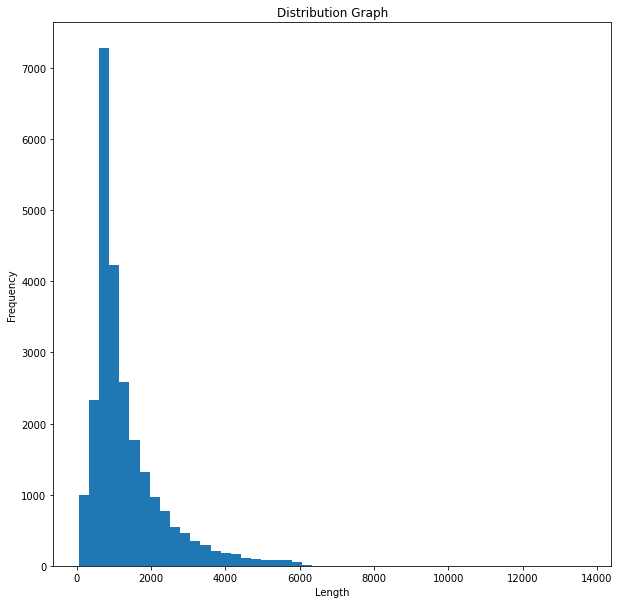

In [71]:
#plotting an histogram for length of the reviews
plt.figure(figsize=(10,10))
plt.hist([len(review) for review in list(X_train)], 50)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution Graph')
plt.show()


From the plot obtained,
we can consider the average movie review length to be approximately around 2000 or lessser than that


In [72]:
"""
The reviews contain a lot of unwanted data that do not hold any information to train the model and 
they need to be removed by doing data preprocessing.The unwanted data observed in the reviews are numbers,
punctuations,html tags and other special characters.These can be identified and removed using the regex matches 
and substitutions.
"""
def remove(row):
    non_alpha = re.compile('[^a-zA-Z]')
    spcl_char = re.compile('[;.!:\',\"()?\[\]]')
    html = re.compile(r'<.*?>')
    row= [html.sub(" ",i) for i in row]
    row = [spcl_char.sub(" ", i) for i in row]
    row = [non_alpha.sub(" ", i.lower()) for i in row]
    return row
#removing the unwanted data from the train and test
X_train=remove(X_train)
X_test=remove(X_train)
#process of tokenization 
"""
Tokenization is the process of splitting a text into a list of tokens thereby creating a word-to-index dictionary 
where each word is considered as a key and a unique index is created for it. 
"""
vocabulary = 5000
tokenizer = Tokenizer(num_words=vocabulary)
#we create the indexes based on word frequency so,we use fit_on_texts funtion from keras tokenizer
tokenizer.fit_on_texts(X_train)
#transforms each text in texts to a sequence of integer using texts_to_sequence to form a valid input to the neural network
X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)
'''
X_train and X_test are now a list of values and each list corresponds to the sentence in the train and test set.
For purpose of training (To provide a proper input to the neural network) we set a max length to the list in such a way that if the size of the list is greater than 
the length mentioned then we truncate it and in the other scenario when the size is small we pad the list with 0
'''
max_length = 500
X_train = sequence.pad_sequences(X_train,maxlen=max_length)
X_test = sequence.pad_sequences(X_test,maxlen=max_length)
'''
We have assigned the vocabulary as 5000 and max length as 500 to train the model
'''

'\nWe have assigned the vocabulary as 5000 and max length as 500 to train the model\n'

#### Model Training
I have considered a sequential model and the vocabulary size to be 5000 and the maximum length of a sentence to be 500.
We will be using the embedding layer that takes as input the reviews and forms embedding vectors which helps in dimensionality reduction and reduces the computational complexity and hence speeds up the training process unlike the large dimensionality produced through one hot encoding of target.We use the dropout layer with 0.2 after every embedding layer inorder to reduce the trainable parameters and help the model to train without overfitting.Flatten layer is used to feed the input to the dense layer.
For the output we use a dense layer with softmax activation function and one neuron that outputs the polarity of the review.
The model is compiled with the adam optimizer and the loss function considered is binary cross entropy as sentimental analysis probelm considered here is a binary classification probelm.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 64)           320000    
_________________________________________________________________
dropout (Dropout)            (None, 500, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 32001     
Total params: 352,001
Trainable params: 352,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
313/313 - 3s - loss: 0.5141 - accuracy: 0.7333 - val_loss: 0.3247 - val_accuracy: 0.8612
Epoch 2/15
313/313 - 3s - loss: 0.2487 - accuracy: 0.9029 - val_loss: 0.2894 - val_accuracy: 0.8802
Epoch 3/15
313/313 - 3s - loss: 0.1617 - accurac

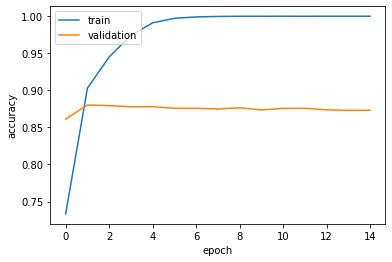

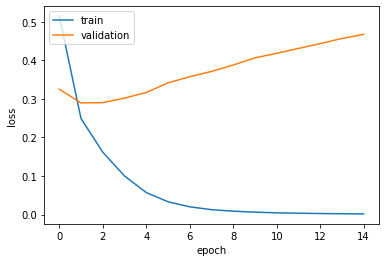

625/625 [==============================] - 1s 1ms/step - loss: 0.1656 - accuracy: 0.9498
Accuracy on train:  0.9497500061988831 Loss on train:  0.16555359959602356
157/157 [==============================] - 0s 940us/step - loss: 0.2894 - accuracy: 0.8802
Accuracy on val:  0.8802000284194946 Loss on val:  0.2893925905227661


In [73]:
if __name__ == "__main__": 
    #load the training dataset and create labels
    y_train = [0 if i < 12500 else 1 for i in range(25000)]
    y_train = np.asarray(y_train)
    # Splitting the training dataset into train and validation data to analyse the performance of the model
    x_train, x_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2,random_state=42)
    #Fixing the vocabulary and maximum length for the review
    vocabulary = 5000
    max_length = 500
    tf.keras.backend.clear_session()
    #defining the model
    imdb=models.Sequential()
    # adding the embedding layer which takes the input length and vocabulary size 
    imdb.add(Embedding(vocabulary,64,input_length=max_length))
    imdb.add(Dropout(0.2))
    imdb.add(Flatten())
    imdb.add(Dense(1, activation='sigmoid'))
    #compiling the model using adam optimizer and binary_crossentropy
    op = tf.keras.optimizers.Adam()
    imdb.compile(optimizer=op,loss='binary_crossentropy',metrics=['accuracy'])
    imdb.summary()
    #store the trained model
    file_name="/Users/chitraaramachandran/Downloads/20820331_NLP_model.h5"
    checkpoint = k.callbacks.ModelCheckpoint(file_name ,
                                 monitor = 'val_loss',
                                 verbose = 0,
                                 save_best_only = True,
                                 mode = 'min')
    history = imdb.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, batch_size=64, verbose=2, callbacks = [checkpoint])
    #loading the trained weights
    imdb.load_weights(file_name) 
    # plotting the training and validation accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','validation'], loc='upper left')
    plt.show()
    # plotting the training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','validation'], loc='upper left')
    plt.show()
    #printing the final obtained results
    loss,accuracy=imdb.evaluate(x_train,y_train)
    print("Accuracy on train: ",accuracy,"Loss on train: ",loss)
    loss,accuracy=imdb.evaluate(x_val,y_val)
    print("Accuracy on val: ",accuracy,"Loss on val: ",loss)

In [75]:
#prediction on test data
vocabulary = 5000
max_length = 500
imdb = models.Sequential()
imdb.add(layers.Embedding(vocabulary, 64, input_length = max_length))
imdb.add(layers.Dropout(0.4))
imdb.add(layers.Flatten())
imdb.add(layers.Dense(1, activation='sigmoid'))
op = tf.keras.optimizers.Adam()
imdb.compile(optimizer=op,loss='binary_crossentropy',metrics=['accuracy'])
if __name__ == "__main__": 
    #creating the test labels
    y_test=[0 if i < 12500 else 1 for i in range(25000)]
    y_test=np.asarray(y_test)
    #loading the trained weights
    imdb.load_weights("/Users/chitraaramachandran/Downloads/20820331_NLP_model.h5")
    loss,accuracy=imdb.evaluate(X_test,y_test)
    #printing the final accuracy obtained on test data
    print("Accuracy on test data : ",accuracy)

782/782 [==============================] - 1s 914us/step - loss: 0.1903 - accuracy: 0.9358
Accuracy on test data :  0.9358400106430054


#### REPORT
From the obtained result we can say that the optimal number of epochs will be 10 after which the training accuracy has reached 100 and there are no more trainable paramters and the validation accuracy also saturates.so is the loss function.The accuracy obtained on test accuracy is 93.5.This reported value might change because of the randomization.